# Packages

In [1]:
import os
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypower.api as pp
from datetime import datetime
import wrf2power.opf as opf

In [2]:
from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition
import numpy as np
import pandas as pd
import pypower.api as pp
# Import pypower data indexing
from pypower.idx_bus import *
from pypower.idx_gen import *
from pypower.idx_brch import *
from pypower.idx_cost import *

def single_opf_new(B, Bf, gen_map, load_map, load, gencost_0, gencost_1, dc_idx_f, dc_idx_t,
                gen_min, gen_max, br_min, br_max, if_map, if_lims):
    '''
    Single-period OPF problem.

    Paraemters:
        A tuple of OPF network parameters and constraints.
    
    Returns:
        model (pyomo.core.base.PyomoModel.ConcreteModel): Pyomo model for single-period OPF problem.
    '''
    # Get problem dimensions
    NB, NG = gen_map.shape
    NL = load.shape[0]
    NBR = br_min.shape[0]

    model = ConcreteModel(name='single-period OPF')

    # Define sets
    model.bus = Set(initialize=range(NB))
    model.brch = Set(initialize=range(NBR))
    model.gen = Set(initialize=range(NG))

    # Define variables
    model.PG = Var(model.gen, within=Reals,initialize=1)  # Real power generation
    model.Va = Var(model.bus, within=Reals, initialize=0,
                   bounds=(-2*np.pi, 2*np.pi))  # Bus voltage angle
    model.PF = Var(model.brch, within=Reals, initialize=0) # Branch power flow

    model.dual = Suffix(direction=Suffix.IMPORT) # Dual variables for price information

    # Define constraints
    model.c_br_flow = ConstraintList()
    model.c_br_max = ConstraintList()
    model.c_br_min = ConstraintList()
    model.c_gen_cap = ConstraintList()
    model.c_pf = ConstraintList()
    model.c_dcline = ConstraintList()
    model.c_if_lims = ConstraintList()

    # Line flow limit constraints
    for br in range(NBR):
        model.c_br_flow.add(model.PF[br] == sum(Bf[br, b]*model.Va[b] for b in range(NB)))
        model.c_br_max.add(model.PF[br] <= br_max[br])
        model.c_br_min.add(model.PF[br] >= br_min[br])
    
    # Generation capacity limit
    for g in range(NG):
        model.c_gen_cap.add(model.PG[g] >= gen_min[g])
        model.c_gen_cap.add(model.PG[g] <= gen_max[g])

    # DC power flow constraint
    for b in range(NB):
        model.c_pf.add(sum(gen_map[b, g]*model.PG[g] for g in range(NG)) - sum(load_map[b, l]*load[l] for l in range(NL))
                        == sum(B[b, b_]*model.Va[b_] for b_ in range(NB)))
    
    # DC line power balance constraint
    for idx_f, idx_t in zip(dc_idx_f, dc_idx_t):
        model.c_dcline.add(model.PG[idx_f] == -model.PG[idx_t])
    
    # Interface flow limits
    for n in range(len(if_lims)):
        if_id, if_lims_down, if_lims_up = if_lims[n, :]
        br_dir_idx = if_map[(if_map[:,0] == int(if_id)), 1]
        br_dir, br_idx = np.sign(br_dir_idx), np.abs(br_dir_idx).astype(int)
        model.c_if_lims.add(if_lims_down <= sum(br_dir[i]*model.PF[br_idx[i]] for i in range(len(br_idx))))
        model.c_if_lims.add(if_lims_up >= sum(br_dir[i]*model.PF[br_idx[i]] for i in range(len(br_idx))))

    def cost(model, gencost_0, gencost_1):

        cost = sum(gencost_0[g] for g in range(NG)) \
            + sum(gencost_1[g]*model.PG[g] for g in range(NG))
            # + sum(model.s_br_min[br]*1e6 for br in range(NBR)) \
            # + sum(model.s_br_max[br]*1e6 for br in range(NBR))

        return cost

    model.obj = Objective(expr=cost(model, gencost_0, gencost_1), sense=minimize)

    return model

In [17]:
# Get problem dimensions
NB, NG = gen_map.shape
NL = load.shape[0]
NBR = br_min.shape[0]

model = ConcreteModel(name='single-period OPF')

# Define sets
model.bus = Set(initialize=range(NB))
model.brch = Set(initialize=range(NBR))
model.gen = Set(initialize=range(NG))

# Define variables
model.PG = Var(model.gen, within=Reals,initialize=1)  # Real power generation
model.Va = Var(model.bus, within=Reals, initialize=0,
                bounds=(-2*np.pi, 2*np.pi))  # Bus voltage angle
model.PF = Var(model.brch, within=Reals, initialize=0) # Branch power flow

In [20]:
model.Va.pprint()

Va : Size=57, Index=bus
    Key : Lower              : Value : Upper             : Fixed : Stale : Domain
      0 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
      1 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
      2 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
      3 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
      4 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
      5 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
      6 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
      7 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
      8 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
      9 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :  Reals
     10 : -6.283185307179586 :     0 : 6.283185307179586 : False : False :

# Single-period OPF

In [2]:
start_time = datetime(2016, 8, 5, 12, 0, 0)
end_time = datetime(2016, 8, 5, 12, 0, 0)
testyear = start_time.year
timestamp_list = pd.date_range(start_time, end_time, freq='1H')

# Read load profile
datadir = '../data'
filename = os.path.join(datadir, f'loadprofile_{testyear}.csv')
load_profile = pd.read_csv(filename, parse_dates=['TimeStamp'])
load_profile = load_profile.set_index('TimeStamp')


load = load_profile.loc[timestamp_list, :].to_numpy()

In [16]:
# Read MATPOWER case file
filename = os.path.join(datadir, 'ny_grid.mat')
ppc = pp.loadcase(filename)

(ppc_int, B, Bf, gen_map, load_map, load_pu, gencost_0, gencost_1, dc_idx_f, dc_idx_t,
    gen_min, gen_max, br_min, br_max, ramp_down, ramp_up, if_map, if_lims) = opf.process_ppc(ppc, load)

In [7]:
# Single-period OPF
# br_max = 6*br_max
# br_min = 10*br_min

model_single = opf.single_opf(B, Bf, gen_map, load_map, load_pu[0], gencost_0, gencost_1, dc_idx_f, dc_idx_t,
                gen_min, gen_max, br_min, br_max, if_map, if_lims)

# model_single.c_br_flow.deactivate()
# model_single.c_br_max.deactivate()
model_single.c_br_min.deactivate()
# Solve the problem
solver = SolverFactory('gurobi')
results_single = solver.solve(model_single, tee=True)

if opf.check_model_status(results_single):
     print('%.2f' % model_single.obj())

Academic license - for non-commercial use only - expires 2022-07-04
Using license file C:\Users\xjtuy\gurobi.lic
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpwhghz8m0.pyomo.lp
Reading time = 0.00 seconds
x429: 818 rows, 429 columns, 1502 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 818 rows, 429 columns and 1502 nonzeros
Model fingerprint: 0x56407d37
Coefficient statistics:
  Matrix range     [1e-01, 5e+02]
  Objective range  [1e+02, 5e+04]
  Bounds range     [6e+00, 6e+00]
  RHS range        [2e-15, 1e+03]
Presolve removed 743 rows and 217 columns
Presolve time: 0.00s
Presolved: 75 rows, 220 columns, 487 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0139895e+05   9.108159e+01   0.000000e+00      0s
      68    1.7167370e+06   

# Process the results

In [8]:
results = opf.opf_results_single(model_single, ppc_int)

In [9]:
results.keys()

dict_keys(['PG', 'VA', 'PF', 'IF', 'LMP'])

In [10]:
a_PG = results['PG']
a_VA = results['VA']
a_PF = results['PF']
a_IF = results['IF']
a_LMP = results['LMP']

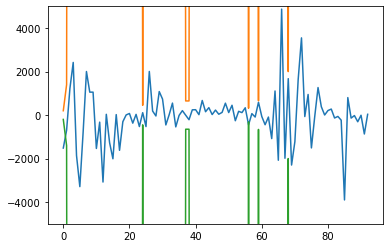

In [14]:
results['PF'].plot()
plt.plot(br_max*100)
plt.plot(br_min*100)
plt.ylim(-5000, 5000)
plt.show()

In [13]:
# Read thermal generator info table
filename = os.path.join(datadir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
gen_info.head()

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,maxRamp10,maxRamp30,maxRamp60,HeatRateLM_R2,HeatRateQM_R2,BusName,NCOST,cost_1,cost_0
0,Allegany,23514,B,Combined Cycle,Natural Gas,42.5083,-78.0661,66.0,11.0,0.733333,7.333333,22.00,44.0,0.862443,0.891407,62,1,22.682017,-40.234372
1,Arthur Kill ST 2,23512,J,Steam Turbine,Natural Gas,40.5915,-74.2027,349.0,96.0,2.850000,28.500000,85.50,171.0,0.995837,0.995860,82,1,25.306225,736.980064
2,Arthur Kill ST 3,23513,J,Steam Turbine,Natural Gas,40.5915,-74.2027,539.0,1.0,3.108333,31.083333,93.25,186.5,0.986235,0.991460,82,1,25.957282,993.894899
3,Astoria 2,24149,J,Steam Turbine,Natural Gas,40.7869,-73.9122,153.0,1.0,0.808333,8.083333,24.25,48.5,0.987563,0.988910,82,1,31.302863,430.832898
4,Astoria 3,23516,J,Steam Turbine,Fuel Oil 2,40.7869,-73.9122,756.0,40.0,6.033333,60.333333,181.00,362.0,0.996075,0.996269,82,1,66.084194,3680.943877


In [16]:
num_thermal = gen_info.shape[0]
thermal_pg = results['PG'][:num_thermal]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
thermal_pg = thermal_pg.rename(index=gen_rename)
thermal_pg

Allegany                         66.0
Arthur Kill ST 2                349.0
Arthur Kill ST 3                539.0
Astoria 2                       153.0
Astoria 3                        40.0
                                ...  
Shoreham 1                        0.0
Shoreham 2                        0.0
South Cairo                       0.0
Southold 1                        0.0
St. Elizabeth Medical Center      0.6
Length: 227, dtype: float64

# Single-period OPF with renewable

In [18]:
# Read solar generation data
filename = f'solar_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.csv'
solar_gen = pd.read_csv(os.path.join(datadir, filename), parse_dates=['TimeStamp'], index_col='TimeStamp')



In [20]:
# Create solar gen matrix in PyPower format
num_solar = solar_gen.shape[1]
gen_solar = np.zeros((num_solar, 21))
for i in range(num_solar):
    gen_solar[i, ]

18

In [ ]:
# Read wind generation data

# Add wind generators

